## Test on a simple case
Consider the following Possion Equation
$$
\begin{cases}
    \Delta u = 0\qquad &u\in\Omega\\
    u(r,\theta) = \sqrt{r}sin(\frac{\theta}{2})\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = (-1,1)\times(-1,1)\backslash[0,1)\times\{0\}$

The exact solution to this problem is $$u = \sqrt{r}sin(\frac{\theta}{2}).$$

In [7]:
% matplotlib inline
import torch 
import torch.nn.functional as F
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 5 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error

#用DeepRitzNet模拟论文中的 -u
class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        self.linear7 = torch.nn.Linear(m,m)
        self.linear8 = torch.nn.Linear(m,m)
        self.linear9 = torch.nn.Linear(m,m)
        self.linear10 = torch.nn.Linear(m,m)
        
        self.linear11 = torch.nn.Linear(m,1)
    
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        y = y + F.relu(self.linear8(F.relu(self.linear7(y))))
        y = y + F.relu(self.linear10(F.relu(self.linear9(y))))
        output = F.relu(self.linear11(y))
        return output

In [8]:
def draw_graph1(mod):
    points = np.arange(-1, 1.1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() 
            #z[i, j] =  U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [9]:
def draw_graph2():
    points = np.arange(-1, 1.1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar() 
    #plt.savefig("loss_1.eps")
    plt.show()

In [10]:
def draw_graph(mod):
    points = np.arange(-1, 1.1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            #z[i, j] =  U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    #plt.savefig("loss_1.eps")
    plt.show()

In [11]:
def cal_loss(mod):
    points = np.arange(-1, 1.1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    n = 0
    for i in np.arange(1, xl):
        for j in np.arange(1, yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            #not on border
            if (i<xl/2 or j != yl/2+1):
                re = torch.tensor(re)        
                z[i, j] = (mod(re.float()).item() - U_groundtruth(re))#/ U_groundtruth(re)           
                if abs(z[i, j]) > mmm:
                    mmm += abs(z[i, j])
                n += 1
    
    return mmm /n 

In [70]:
#U_groundtruth (r, theta) = sqrt(r) * sin(theta/2)
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    theta = atan2(t[1].item(), t[0].item()) + 2*pi #-pi < atan(·) < pi
    return sqrt(sqrt((t[0] ** 2 + t[1] ** 2).item())) * sin(theta/2)

In [76]:
#相对误差
#余冰的例子里面是
#print(np.linalg.norm(np.reshape(u_solve[:,0]-pu,[-1]),ord=2)/np.linalg.norm(np.reshape(pu,[-1]),ord=2))
def relative_err(mod):    
    points = np.arange(-1, 1.1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    w = np.zeros((xl, yl))
    n = 0
    for i in np.arange(1, xl):
        for j in np.arange(1, yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            #not on border
            if (i<xl/2 or j != yl/2+1):
                re = torch.tensor(re)        
                z[i, j] = (mod(re.float()).item() - U_groundtruth(re))#/ U_groundtruth(re)           
                w[i, j] = U_groundtruth(re)
                n += 1
    z = z ** 2
    w = w ** 2
    return np.sum(z) / np.sum(w)

In [100]:
model = DeepRitzNet(m)

In [103]:
train(model, learning_rate=0.001, beta=50, beta_increase=1.01, iterations=10000)

0  epoch, loss:  7.1988065e-06
0  epoch, regularization loss:  37.236332
0  loss to real solution:  0.004979210743492154
1  epoch, loss:  1.635388e-05
1  epoch, regularization loss:  37.90547
1  loss to real solution:  0.004989483902042416
2  epoch, loss:  5.851051e-06
2  epoch, regularization loss:  38.05938
2  loss to real solution:  0.004983258941953686
3  epoch, loss:  7.074004e-06
3  epoch, regularization loss:  38.21535
3  loss to real solution:  0.004977094033544568
4  epoch, loss:  1.0460918e-05
4  epoch, regularization loss:  38.479958
4  loss to real solution:  0.004975070753877667
5  epoch, loss:  8.1220505e-06
5  epoch, regularization loss:  38.843914
5  loss to real solution:  0.004976585605924633
6  epoch, loss:  4.968795e-06
6  epoch, regularization loss:  39.275566
6  loss to real solution:  0.004979747930353192
7  epoch, loss:  4.6258197e-06
7  epoch, regularization loss:  39.72231
7  loss to real solution:  0.004982938268964794
8  epoch, loss:  6.601671e-06
8  epoch, 

67  epoch, loss:  1.6570286e-06
67  epoch, regularization loss:  71.853966
67  loss to real solution:  0.0049805299432926445
68  epoch, loss:  1.6419981e-06
68  epoch, regularization loss:  72.56839
68  loss to real solution:  0.004980709204261807
69  epoch, loss:  1.5773206e-06
69  epoch, regularization loss:  73.27429
69  loss to real solution:  0.004980651983802822
70  epoch, loss:  1.6105705e-06
70  epoch, regularization loss:  73.977356
70  loss to real solution:  0.004980518767421749
71  epoch, loss:  1.5554563e-06
71  epoch, regularization loss:  74.68834
71  loss to real solution:  0.004980289885585812
72  epoch, loss:  1.6397208e-06
72  epoch, regularization loss:  75.41344
72  loss to real solution:  0.004980132231300381
73  epoch, loss:  1.5190182e-06
73  epoch, regularization loss:  76.15059
73  loss to real solution:  0.004980160543506649
74  epoch, loss:  1.552724e-06
74  epoch, regularization loss:  76.89699
74  loss to real solution:  0.004980352321451214
75  epoch, los

133  epoch, loss:  1.3555003e-06
133  epoch, regularization loss:  137.15344
133  loss to real solution:  0.0049804119260959895
134  epoch, loss:  1.3067657e-06
134  epoch, regularization loss:  138.45723
134  loss to real solution:  0.004980554232185391
135  epoch, loss:  1.2102033e-06
135  epoch, regularization loss:  139.80168
135  loss to real solution:  0.004980757335012463
136  epoch, loss:  1.3263505e-06
136  epoch, regularization loss:  141.16743
136  loss to real solution:  0.004980922886913326
137  epoch, loss:  1.2931007e-06
137  epoch, regularization loss:  142.52118
137  loss to real solution:  0.004980959841793088
138  epoch, loss:  1.2730592e-06
138  epoch, regularization loss:  143.86945
138  loss to real solution:  0.004980848381107357
139  epoch, loss:  1.2111143e-06
139  epoch, regularization loss:  145.22142
139  loss to real solution:  0.004980629334037808
140  epoch, loss:  1.2170349e-06
140  epoch, regularization loss:  146.6064
140  loss to real solution:  0.004

KeyboardInterrupt: 

In [72]:
train(the_model, learning_rate=0.001, beta=1, iterations=130)

0  epoch, loss:  0.24080813
0  epoch, regularization loss:  7.472088
0  loss to real solution:  0.014580638001853918
1  epoch, loss:  0.22440334
1  epoch, regularization loss:  7.5816307
1  loss to real solution:  0.014276699315006232
2  epoch, loss:  0.20911102
2  epoch, regularization loss:  7.6856513
2  loss to real solution:  0.013963661383087134
3  epoch, loss:  0.19415504
3  epoch, regularization loss:  7.7909102
3  loss to real solution:  0.013653952966625188
4  epoch, loss:  0.18013532
4  epoch, regularization loss:  7.9060073
4  loss to real solution:  0.013352498005325293
5  epoch, loss:  0.1676016
5  epoch, regularization loss:  8.025424
5  loss to real solution:  0.012894802149835951
6  epoch, loss:  0.15539083
6  epoch, regularization loss:  8.150001
6  loss to real solution:  0.012612094935480482
7  epoch, loss:  0.1437958
7  epoch, regularization loss:  8.281304
7  loss to real solution:  0.012338446137014753
8  epoch, loss:  0.13368683
8  epoch, regularization loss:  8.

68  epoch, loss:  0.006582539
68  epoch, regularization loss:  67.833244
68  loss to real solution:  0.011743399640280521
69  epoch, loss:  0.006410364
69  epoch, regularization loss:  70.91165
69  loss to real solution:  0.011852542197714987
70  epoch, loss:  0.006189526
70  epoch, regularization loss:  74.13229
70  loss to real solution:  0.01182278279067153
71  epoch, loss:  0.0059702927
71  epoch, regularization loss:  77.50413
71  loss to real solution:  0.011728193307710346
72  epoch, loss:  0.0057851705
72  epoch, regularization loss:  81.0406
72  loss to real solution:  0.01170058860857552
73  epoch, loss:  0.0056371004
73  epoch, regularization loss:  84.747444
73  loss to real solution:  0.011673259878946003
74  epoch, loss:  0.005493936
74  epoch, regularization loss:  88.63298
74  loss to real solution:  0.011589628648199832
75  epoch, loss:  0.0053395573
75  epoch, regularization loss:  92.69498
75  loss to real solution:  0.011563215147890842
76  epoch, loss:  0.005168119

In [73]:
#only save the parameters
PATH = './2/test_parameters.pkl'
torch.save(model.state_dict(), PATH)

In [47]:
m = 10
PATH = './2/test_parameters.pkl'
#从文件读取the_model
the_model = DeepRitzNet(m)
the_model.load_state_dict(torch.load(PATH))

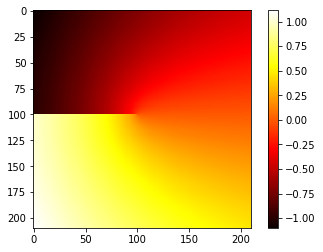

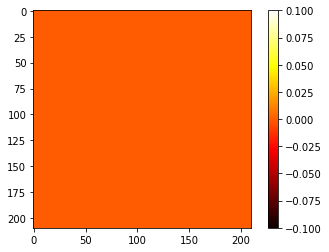

0.005254674461320585
1.0


In [81]:
draw_graph(model)
draw_graph1(model)
print(cal_loss(model))
print(relative_err(model))

In [53]:
def train(mod, learning_rate=0.01, beta=1, beta_increase=1.05, iterations=10000, add_gamma=False, gamma=1, gamma_increase=1.02):    

    optimizer = torch.optim.Adam(mod.parameters(), lr=learning_rate)
    points = np.arange(-1, 1.1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()

    for k in range(iterations):
        loss = torch.zeros(1)
        i1=0
        for i in np.arange(1, xl):
            for j in np.arange(1, yl):        
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]

                #if (x,y)is not on x轴正半轴
                if (abs(x_input[1]) > 0.001 or x_input[0] < 0.001): 
                    x_input = torch.tensor(x_input).float()
                    y = mod(x_input)

                    x1 = torch.zeros(m)
                    x2 = torch.zeros(m)
                    x1[0] = 0.0001
                    x2[1] = 0.0001
                    x_input_1 = x_input.float() + x1
                    x_input_2 = x_input.float() + x2
                    x_input_grad_1 = (mod(x_input_1) - y) / 0.0001
                    x_input_grad_2 = (mod(x_input_2) - y) / 0.0001
                    x_input_2_grad_x = (mod(x_input_1) + mod(x_input_3) - 2 * y) / 0.0001**2
                    x_input_2_grad_y = (mod(x_input_2) + mod(x_input_4) - 2 * y) / 0.0001**2

                    loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2)
                    i1+=1
        if add_gamma:
            loss += gamma * (x_input_2_grad_x + x_input_2_grad_y) ** 2
        loss/=i1
        if gamma < 500:
            gamma *= gamma_increase
        
        regularization = torch.zeros(1)
        i2 = 0
        for i in range(xl):
            for j in range(yl): 
                if (i==0 or i==xl-1) or (j==0 or j==yl-1) or (i>=xl/2 and j==yl/2+1):
                    x_input = np.zeros(m)
                    x_input[0] = xs[i, j]
                    x_input[1] = ys[i, j]           
                    x_input = torch.tensor(x_input).float()
                    y = mod(x_input)
                    regularization += (y.item()-U_groundtruth(x_input))**2 
                    i2 += 1
        #print("i1:",i1,"i2:",i2)
        regularization *= beta / i2
        if beta < 500:
            beta *= beta_increase
        

        #print loss
        print(k, " epoch, loss: ", loss.data[0].numpy())
        print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
        print(k, " loss to real solution: ", cal_loss(mod))
        if cal_loss(mod) < 0.0001:
            break

        loss += regularization

        #and step the optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()